## Import stuff

In [2]:
import tensorflow as tf
from keras.losses import categorical_crossentropy, mean_squared_error
from tensorflow.keras import layers

import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import random
from PIL import Image
import logging
import time

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import sklearn.metrics as metrics
from sklearn.svm import SVC
from sklearn import svm
from sklearn import datasets
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet
from sklearn.model_selection import cross_val_score,StratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import HistGradientBoostingRegressor, ExtraTreesRegressor, RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.mixture import BayesianGaussianMixture, GaussianMixture
from sklearn.kernel_approximation import Nystroem
from sklearn.preprocessing import MinMaxScaler

from tqdm import tqdm
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier, CatBoostRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from xgboost import XGBClassifier, XGBRFClassifier, XGBRegressor, XGBRFRegressor

from flaml import AutoML

import eli5
from eli5.sklearn import PermutationImportance

import shap


logger = tf.get_logger()
logger.setLevel(logging.ERROR)

print(tf.__version__)

def get_score(df_true, df_submission):
    for i in range(df_true.shape[1]):
        print("score for col ",i,": " , metrics.roc_auc_score(df_true[:,i], df_submission[:,i]))

def get_type(model):
    return str(type(model)).split(".")[-1].split("'")[0]

ny = Nystroem(random_state=1, n_components=2000,kernel='linear',degree=3)
scaler = MinMaxScaler()


2.8.0


# feature importance

In [37]:
df = pd.read_csv("train_features_improved.csv")
labels_df = pd.read_csv("train_labels.csv")
df.drop(['pid'], axis=1, inplace=True)
labels_df.drop(['pid'], axis=1, inplace=True)
drop = np.concatenate([[col+"_"+str(x) for x in range(1,12)] for col in pd.read_csv("train_features.csv").columns[3:]])
# print(drop)
df.drop(drop, axis=1, inplace=True)
# df

X = pd.DataFrame(scaler.fit_transform(X),columns=df.columns)
# X = df
Y = labels_df
skf = StratifiedKFold(n_splits=3,random_state=42,shuffle=True)
col = 5
perm = None
for train, test in skf.split(X, Y.iloc[:,col]):
    X_train, X_valid, Y_train, Y_valid = X.iloc[train], X.iloc[test], Y.iloc[train,col], Y.iloc[test,col]
    model = Ridge()
    # model = HistGradientBoostingClassifier()
    # print("fitting model")
    model.fit(X_train, Y_train)
    print("PermutationImportance")
    perm = PermutationImportance(model, random_state=1).fit(X_valid, Y_valid)
    break

print("show_weights")
eli5.show_weights(perm, feature_names = X_valid.columns.tolist())

PermutationImportance
show_weights


Weight,Feature
0.1283 ± 0.0131,Alkalinephos_12
0.1027 ± 0.0027,BaseExcess_12
0.0638 ± 0.0096,Hgb_12
0.0578 ± 0.0045,Platelets_12
0.0329 ± 0.0037,pH_12
0.0293 ± 0.0039,ABPd_12
0.0193 ± 0.0071,Lactate_12
0.0127 ± 0.0033,0
0.0119 ± 0.0023,SpO2_12
0.0101 ± 0.0050,Bilirubin_direct_12


# Shap values

In [5]:
df = pd.read_csv("train_features_improved.csv")
labels_df = pd.read_csv("train_labels.csv")
df.drop(['pid'], axis=1, inplace=True)
labels_df.drop(['pid'], axis=1, inplace=True)
drop = np.concatenate([[col+"_"+str(x) for x in range(1,12)] for col in pd.read_csv("train_features.csv").columns[3:]])
# print(drop)
df.drop(drop, axis=1, inplace=True)
# df

# X = pd.DataFrame(scaler.fit_transform(X),columns=df.columns)
X = df
Y = labels_df
skf = StratifiedKFold(n_splits=3,random_state=42,shuffle=True)
col = 10
for train, test in skf.split(X, Y.iloc[:,col]):
    X_train, X_valid, Y_train, Y_valid = X.iloc[train], X.iloc[test], Y.iloc[train,col], Y.iloc[test,col]
    model = RandomForestClassifier()
    # model = XGBClassifier()
    print("fitting model")
    model.fit(X_train, Y_train)
    # Create object that can calculate shap values
    explainer = shap.TreeExplainer(model)
    break


fitting model


In [8]:
np.argmax(model.predict_proba(X_valid)[:,1])
model.predict_proba(X_valid)[3958,1]

0.43

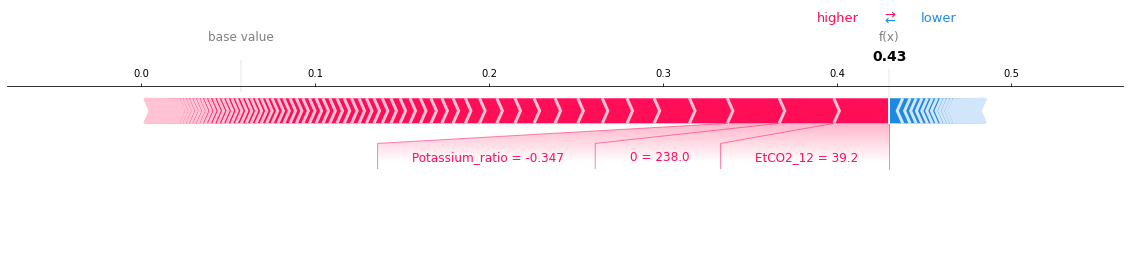

None

In [11]:
# Calculate Shap values
row = 3958
shap_values = explainer.shap_values(X_valid.iloc[row,:])
shap.initjs()
# shap_display = shap.force_plot(np.mean(Y.iloc[:,col]), shap_values[0], X_valid.iloc[row,:], matplotlib=True)
shap_display = shap.force_plot(explainer.expected_value[1], shap_values[1], X_valid.iloc[row,:], matplotlib=True)
display(shap_display)

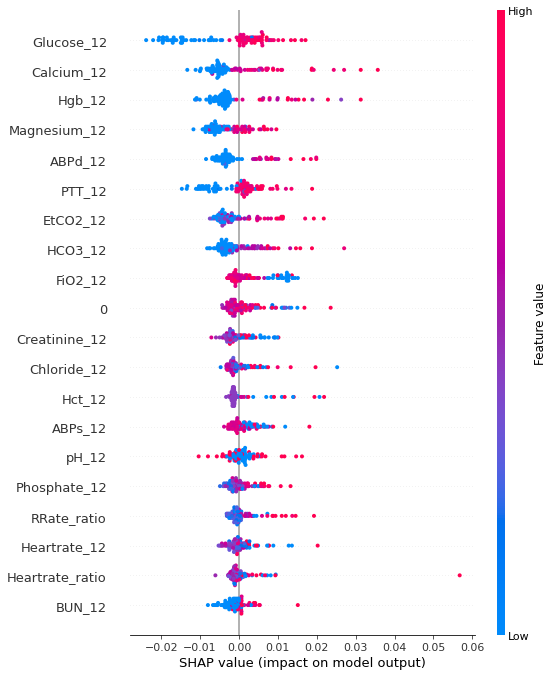

In [10]:
shap_values = explainer.shap_values(X_valid.iloc[:100,:])
shap.summary_plot(shap_values[1], X_valid.iloc[:100,:])